In this notebook, we compare healthcare utilization across race and gender for schizophrenia patients and non-schizophrenia patients. Note that these graphs made it into the presentation, but there was not enough space in the paper. 

In [1]:
import numpy as np
import os
import pandas as pd
import pyodbc
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
import sys
import gc
from scipy.sparse import csr_matrix
import pickle
import joblib
from itertools import product
import matplotlib
from sklearn.preprocessing import MinMaxScaler

In [2]:
connection_string = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=OMOP.DBMI.COLUMBIA.EDU;'
    'DATABASE=cdm_mdcd;'
    'TRUSTED_CONNECTION=YES;')

conn = pyodbc.connect(connection_string)

In [3]:
path = '../'

## Import Visit Data + Populaion Information

In [4]:
num_days_prediction = 90
df_pop = pd.read_csv(path+'population.csv')
df_pop.rename({'psychosis_dx_date':'psychosis_diagnosis_date'}, axis=1, inplace=True)
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

In [5]:
all_visits = pd.read_csv(path+'temporal_visits.csv')
df_pop = df_pop.merge(all_visits.groupby('person_id').min()['visit_start_date'], how='left', left_on='person_id',right_index=True)
df_pop.rename({'visit_start_date':'first_visit'}, axis=1, inplace=True)
df_pop.head()

,cohort_definition_id,person_id,end_date,year_of_birth,race_concept_id,gender_concept_id,psychosis_diagnosis_date,age_diagnosis,sz_flag,cohort_start_date,first_visit
0,4149,20000707486,2017-12-31 00:00:00,2002-01-01,8527,8532,2016-12-30,16.008219,0,2017-12-31,2008-03-10
1,4149,20000709281,2016-03-31 00:00:00,1996-01-01,8516,8507,2008-03-05,20.260274,0,2016-03-31,2008-01-11
2,4149,20000715309,2015-05-31 00:00:00,1996-01-01,8527,8507,2008-12-05,19.424658,0,2015-05-31,2008-12-05
3,4149,20000721050,2017-12-31 00:00:00,2002-01-01,8516,8532,2016-07-06,16.008219,0,2017-12-31,2008-08-07
4,4149,20000727283,2016-06-30 00:00:00,1997-01-01,8527,8507,2013-03-12,19.506849,0,2016-06-30,2008-01-10


In [6]:
# limit to only visits pre-censor
all_visits = all_visits.loc[all_visits['person_id'].isin(df_pop['person_id'])]
all_visits['cohort_start_date'] = pd.to_datetime(all_visits['cohort_start_date'])
all_visits['visit_start_date'] = pd.to_datetime(all_visits['visit_start_date'])
all_visits['visit_end_date'] = pd.to_datetime(all_visits['visit_end_date'])
all_visits = all_visits.loc[(all_visits['cohort_start_date']-all_visits['visit_end_date']).dt.days >= num_days_prediction]
all_visits['days_to_cohort_start'] = (all_visits['cohort_start_date']-all_visits['visit_start_date']).dt.days

In [7]:
all_visits = all_visits.merge(df_pop[['person_id', 'psychosis_diagnosis_date', 'first_visit', 'race_concept_id', 'gender_concept_id', 'sz_flag']], how = 'left', left_on = 'person_id', right_on = 'person_id')

## Get heathcare utilization (inpatient, outpatient, ED, MH) per patient
dropping visits of the same type that start on the same day

In [8]:
unique_start_visits = all_visits[['person_id', 'visit_concept_id', 'visit_start_date', 'cohort_start_date', 'psychosis_diagnosis_date', 'race_concept_id', 'gender_concept_id', 'first_visit', 'sz_flag']].drop_duplicates()

In [9]:
df_hcu = pd.DataFrame(unique_start_visits.groupby(['person_id', 'visit_concept_id']).count()['visit_start_date'])
df_hcu = pd.pivot_table(df_hcu, index='person_id', columns = 'visit_concept_id', values = 'visit_start_date').fillna(0)
df_hcu.columns = ['Inpatient', 'Outpatient', 'ED', 'Nonhospitalization']
df_hcu = df_hcu.merge(df_pop[['person_id', 'cohort_start_date', 'psychosis_diagnosis_date', 'race_concept_id', 'gender_concept_id', 'first_visit', 'sz_flag']], how='left', left_index=True, right_on='person_id')

df_hcu['time_to_diagnosis'] = (df_hcu['cohort_start_date']-df_hcu['psychosis_diagnosis_date']).dt.days/365

df_hcu['is_Black'] = (df_hcu['race_concept_id'] == 8516)*1
df_hcu['is_White'] = (df_hcu['race_concept_id'] == 8527)*1
df_hcu['is_Female'] = (df_hcu['gender_concept_id'] == 8532)*1

In [10]:
df_hcu['first_visit'] = pd.to_datetime(df_hcu['first_visit'])
df_hcu['years_obs'] = (df_hcu['cohort_start_date']-df_hcu['first_visit']).dt.days/365

df_hcu[['Inpatient', 'Outpatient', 'ED', 'Nonhospitalization']] = df_hcu[['Inpatient', 'Outpatient', 'ED', 'Nonhospitalization']].div(df_hcu['years_obs'], axis=0)

### Add mental health inpatient visits

In [11]:
query = ("SELECT vo.person_id, vo.visit_occurrence_id, vo.visit_concept_id, co.condition_start_date, vo.visit_start_date, vo.visit_end_date, co.condition_concept_id, c.concept_name as condition_name, p.race_concept_id, p.gender_concept_id "+
         "FROM dbo.visit_occurrence as vo LEFT JOIN dbo.condition_occurrence as co on co.visit_occurrence_id = vo.visit_occurrence_id "+
         "LEFT JOIN dbo.concept as c on c.concept_id = co.condition_concept_id "+
         "LEFT JOIN dbo.person as p on p.person_id = vo.person_id "+
         "WHERE vo.visit_concept_id = 9201 AND condition_concept_id IN "+
         "(SELECT DISTINCT concept_id_2 FROM dbo.concept as c LEFT JOIN dbo.concept_relationship on concept_id_1 = concept_id WHERE c.concept_code LIKE 'F%' AND c.vocabulary_id = 'ICD10CM' AND relationship_id = 'Maps to')")

psych_hosp = pd.io.sql.read_sql(query, conn)
list_psych_visits = list(psych_hosp['visit_occurrence_id'].unique())

/tmp/ipykernel_480009/124869976.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  psych_hosp = pd.io.sql.read_sql(query, conn)


In [12]:
psych_hosp_visits = all_visits.loc[all_visits['visit_occurrence_id'].isin(list_psych_visits)]
psych_hosp_visits = psych_hosp_visits[['person_id', 'visit_concept_id', 'visit_start_date']].drop_duplicates()
psych_hosp_visits = psych_hosp_visits.groupby('person_id').count()['visit_concept_id']
psych_hosp_visits.name = 'Psych_Inpatient'

df_hcu = df_hcu.merge(psych_hosp_visits, how='left', left_on = 'person_id', right_index=True)

In [13]:
df_hcu.fillna(0, inplace=True)
df_hcu['Psych_Inpatient'] = df_hcu['Psych_Inpatient'].div(df_hcu['years_obs'], axis=0)

### Identify the percentile in the distribution for each patient

In [14]:
# get the feature columns
cols = ['Inpatient', 'Outpatient', 'ED', 'Nonhospitalization','Psych_Inpatient']

# replace columns in df_results with percentiles 
for ind in tqdm(range(len(cols))):
    col = cols[ind]
    df_hcu[col] = stats.percentileofscore(df_hcu[col], df_hcu[col], kind='weak')

100%|██████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.87s/it]


In [15]:
df_hcu['All'] = df_hcu[['Inpatient', 'Outpatient', 'ED', 'Psych_Inpatient']].mean(axis=1)
cols.append('All')

In [16]:
df_hcu.to_csv('stored_data/hcu_perpatient.csv')

### Correlation: for each healthcare utilization feature (and combined)
Is there a correlation between HCU and race, gender, or time to diagnosis? 
Look overall, in the no_scz_cohort, in the scz_cohort

Note: I am not reporting this in the manuscript

In [17]:
hcu_results = pd.DataFrame(columns = ['Inpatient', 'Outpatient', 'ED', 'Nonhospitalization', 'All', 'Psych_Inpatient'])
for sz_flag in [[0], [1], [0, 1]]:
    subset = df_hcu.loc[df_hcu['sz_flag'].isin(sz_flag)]
    for col in ['is_Black', 'is_White', 'is_Female', 'time_to_diagnosis']:
        list_row = []
        ind_name = str(sz_flag)+'_'+col
        for hcu_col in hcu_results.columns:
            (stat, pval) = (stats.spearmanr(subset[col], subset[hcu_col]))
            pval *= 72
            list_row.append((stat, pval))
        hcu_results.loc[ind_name] = list_row
        



### Median values: differences

In [17]:
def create_gender_results(dx_subset, cols):
    female_subset = dx_subset.loc[dx_subset['gender_concept_id']==8532, cols]
    male_subset = dx_subset.loc[dx_subset['gender_concept_id']==8507, cols]
    gender_grouped_results = pd.DataFrame(data=np.asarray([female_subset.mean(axis=0), male_subset.mean(axis=0)]).T, index=cols, columns = ['female mean percentile', 'male mean percentile'])
    gender_grouped_results['difference'] = gender_grouped_results['male mean percentile']-gender_grouped_results['female mean percentile']
    gender_grouped_results['pval'] = stats.mannwhitneyu(female_subset.values, male_subset.values).pvalue
    
    ci_low, ci_high = stats.ttest_ind(male_subset.values, female_subset.values).confidence_interval()
    gender_grouped_results['95_ci_low'] = ci_low
    gender_grouped_results['95_ci_high'] = ci_high

    
    gender_grouped_results['pval']*=len(cols)
    
    return gender_grouped_results

dx_subset = df_hcu.loc[df_hcu['sz_flag']==0]
no_scz_gender_grouped_results = create_gender_results(dx_subset, cols)

dx_subset = df_hcu.loc[df_hcu['sz_flag']==1]
scz_gender_grouped_results = create_gender_results(dx_subset, cols)

gender_grouped_results = no_scz_gender_grouped_results.merge(scz_gender_grouped_results, how='inner', left_index=True, right_index=True, suffixes=['_noscz', '_scz'])

In [18]:
def create_race_results(dx_subset, cols):
    black_subset = dx_subset.loc[dx_subset['race_concept_id']==8516, cols]
    white_subset = dx_subset.loc[dx_subset['race_concept_id']==8527, cols]
    race_grouped_results = pd.DataFrame(data=np.asarray([black_subset.mean(axis=0), white_subset.mean(axis=0)]).T, index=cols, columns = ['black mean percentile', 'white mean percentile'])
    
    race_grouped_results['difference'] = race_grouped_results['white mean percentile']-race_grouped_results['black mean percentile']
    race_grouped_results['pval'] = stats.mannwhitneyu(black_subset.values, white_subset.values).pvalue
    ci_low, ci_high = stats.ttest_ind(white_subset.values, black_subset.values).confidence_interval()
    race_grouped_results['95_ci_low'] = ci_low
    race_grouped_results['95_ci_high'] = ci_high
    

    
    race_grouped_results['pval']*=len(cols)
    return race_grouped_results

dx_subset = df_hcu.loc[df_hcu['sz_flag'].isin([0,1])]
no_scz_race_grouped_results = create_race_results(dx_subset, cols)

dx_subset = df_hcu.loc[df_hcu['sz_flag']==1]
scz_race_grouped_results = create_race_results(dx_subset, cols)

race_grouped_results = no_scz_race_grouped_results.merge(scz_race_grouped_results, how='inner', left_index=True, right_index=True, suffixes=['_noscz', '_scz'])
race_grouped_results

,black mean percentile_noscz,white mean percentile_noscz,difference_noscz,pval_noscz,95_ci_low_noscz,95_ci_high_noscz,black mean percentile_scz,white mean percentile_scz,difference_scz,pval_scz,95_ci_low_scz,95_ci_high_scz
Inpatient,63.940472,63.428934,-0.511538,4.057475e+00,-0.736105,-0.286972,70.333183,74.407004,4.073821,2.226838e-04,2.166018,5.981624
Outpatient,48.439112,49.991686,1.552574,1.459787e-12,1.132818,1.972330,63.198284,71.096670,7.898386,2.399779e-06,4.830392,10.966379
ED,52.000887,49.919033,-2.081854,8.427642e-22,-2.499500,-1.664208,56.733574,58.875312,2.141738,1.095574e+00,-1.148275,5.431751
Nonhospitalization,99.064837,99.066544,0.001707,6.088195e-05,0.000928,0.002486,99.074163,99.081013,0.006850,3.972089e-01,-0.004207,0.017906
Psych_Inpatient,70.952271,71.661196,0.708926,2.117395e-29,0.561028,0.856823,77.477766,81.592272,4.114507,1.114469e-07,2.689271,5.539742
All,58.833185,58.750212,-0.082973,1.390658e+00,-0.293519,0.127573,66.935702,71.492814,4.557113,8.756228e-07,2.871136,6.243089


In [19]:
gender_grouped_results

,female mean percentile_noscz,male mean percentile_noscz,difference_noscz,pval_noscz,95_ci_low_noscz,95_ci_high_noscz,female mean percentile_scz,male mean percentile_scz,difference_scz,pval_scz,95_ci_low_scz,95_ci_high_scz
Inpatient,65.796901,60.617377,-5.179523,0.000000e+00,-5.367675,-4.991371,74.945203,69.437563,-5.507639,2.134397e-10,-7.123988,-3.891291
Outpatient,47.200357,52.518506,5.318149,5.406307e-183,4.960448,5.675850,65.283699,69.816252,4.532553,4.311021e-04,1.920701,7.144406
ED,55.339234,44.068805,-11.270429,0.000000e+00,-11.619876,-10.920983,63.991435,51.988948,-12.002487,4.874437e-19,-14.735779,-9.269195
Nonhospitalization,99.065515,99.065953,0.000438,3.791542e-01,-0.000203,0.001080,99.074392,99.079062,0.004670,1.734039e+00,-0.004226,0.013567
Psych_Inpatient,71.583279,70.902337,-0.680942,2.907762e-48,-0.805613,-0.556272,80.512125,78.514848,-1.997277,7.135893e-03,-3.220380,-0.774174
All,59.979943,57.026756,-2.953186,7.363771e-224,-3.131848,-2.774525,71.183115,67.439403,-3.743712,1.257597e-06,-5.174170,-2.313255


In [20]:
create_gender_results(df_hcu, cols)

,female mean percentile,male mean percentile,difference,pval,95_ci_low,95_ci_high
Inpatient,65.940116,60.776467,-5.163649,0.000000e+00,-5.351154,-4.976145
Outpatient,47.483450,52.830506,5.347056,1.293269e-188,4.991548,5.702564
ED,55.474683,44.211660,-11.263023,0.000000e+00,-11.609881,-10.916165
Nonhospitalization,99.065654,99.066190,0.000536,1.989007e-01,-0.000113,0.001184
Psych_Inpatient,71.723059,71.039643,-0.683415,4.440109e-48,-0.808388,-0.558443
All,60.155327,57.214569,-2.940758,1.184650e-223,-3.118872,-2.762644


### Create plot based off these results
Specifically want to plot difference for male scz to no scz, female scz to no scz
(same for Black and white)

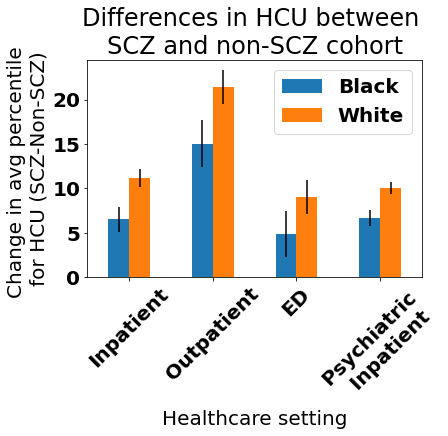

In [107]:
font = {'size':20,
       'weight':'bold'}
matplotlib.rc('font', **font)

cols = ['Inpatient', 'Outpatient', 'ED', 'Psych_Inpatient']
black_subset = df_hcu.loc[df_hcu['race_concept_id']==8516, cols+['sz_flag']]
white_subset = df_hcu.loc[df_hcu['race_concept_id']==8527, cols+['sz_flag']]

s1_noscz = black_subset.loc[black_subset['sz_flag']==0]
s1_scz = black_subset.loc[black_subset['sz_flag']==1]

s2_noscz = white_subset.loc[white_subset['sz_flag']==0]
s2_scz = white_subset.loc[white_subset['sz_flag']==1]

df_for_plot = pd.DataFrame(index=cols)
df_for_plot['s1_change'] = s1_scz[cols].mean(axis=0)-s1_noscz[cols].mean(axis=0)
cis = stats.ttest_ind(s1_scz[cols], s1_noscz[cols]).confidence_interval()
df_for_plot['s1_yerr'] = df_for_plot['s1_change']-cis.low

df_for_plot['s2_change'] = s2_scz[cols].mean(axis=0)-s2_noscz[cols].mean(axis=0)
cis = stats.ttest_ind(s2_scz[cols], s2_noscz[cols]).confidence_interval()
df_for_plot['s2_yerr'] = df_for_plot['s2_change']-cis.low

df_for_plot.index = ['Inpatient', 'Outpatient', 'ED', 'Psychiatric \n Inpatient']
df_for_plot.reset_index(inplace=True)
ax = df_for_plot.plot.bar(x='index', 
                y=['s1_change', 's2_change'],
                yerr=df_for_plot[['s1_yerr', 's2_yerr']].T.values, rot=45)
plt.legend(['Black','White'])
plt.title('Differences in HCU between \nSCZ and non-SCZ cohort')
plt.ylabel('Change in avg percentile \nfor HCU (SCZ-Non-SCZ)')
plt.xlabel('Healthcare setting')
plt.show()

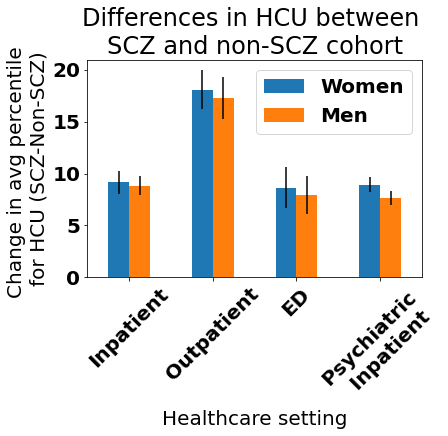

In [109]:
font = {'size':20,
       'weight':'bold'}
matplotlib.rc('font', **font)

cols = ['Inpatient', 'Outpatient', 'ED', 'Psych_Inpatient']
female_subset = df_hcu.loc[df_hcu['gender_concept_id']==8532, cols+['sz_flag']]
male_subset = df_hcu.loc[df_hcu['gender_concept_id']==8507, cols+['sz_flag']]

s1_noscz = female_subset.loc[female_subset['sz_flag']==0]
s1_scz = female_subset.loc[female_subset['sz_flag']==1]

s2_noscz = male_subset.loc[male_subset['sz_flag']==0]
s2_scz = male_subset.loc[male_subset['sz_flag']==1]

df_for_plot = pd.DataFrame(index=cols)
df_for_plot['s1_change'] = s1_scz[cols].mean(axis=0)-s1_noscz[cols].mean(axis=0)
cis = stats.ttest_ind(s1_scz[cols], s1_noscz[cols]).confidence_interval()
df_for_plot['s1_yerr'] = df_for_plot['s1_change']-cis.low

df_for_plot['s2_change'] = s2_scz[cols].mean(axis=0)-s2_noscz[cols].mean(axis=0)
cis = stats.ttest_ind(s2_scz[cols], s2_noscz[cols]).confidence_interval()
df_for_plot['s2_yerr'] = df_for_plot['s2_change']-cis.low

df_for_plot.index = ['Inpatient', 'Outpatient', 'ED', 'Psychiatric \n Inpatient']
df_for_plot.reset_index(inplace=True)
ax = df_for_plot.plot.bar(x='index', 
                y=['s1_change', 's2_change'],
                yerr=df_for_plot[['s1_yerr', 's2_yerr']].T.values, rot=45)
plt.legend(['Women','Men'])
plt.title('Differences in HCU between \nSCZ and non-SCZ cohort')
plt.ylabel('Change in avg percentile \nfor HCU (SCZ-Non-SCZ)')
plt.xlabel('Healthcare setting')
plt.show()